In [473]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

bits_minuto = 90
pulses_number = 300
distance = 0.6
print(pulses_number)

300


In [474]:
df = pd.DataFrame()

sensor1=np.loadtxt("sensor_data1.txt", delimiter=",")
sensor2=np.loadtxt("sensor_data2.txt", delimiter=",")

if len(sensor1) >= len(sensor2):
    df["sensor2"] = np.loadtxt("sensor_data2.txt", delimiter=",")
    df["sensor1"] = np.loadtxt("sensor_data1.txt", delimiter=",")[:len(sensor2)]
else:
    df["sensor1"] = np.loadtxt("sensor_data1.txt", delimiter=",")
    df["sensor2"] = np.loadtxt("sensor_data2.txt", delimiter=",")[:len(sensor1)]
    

In [475]:
df = df[8000:]
df = df[:-8000]


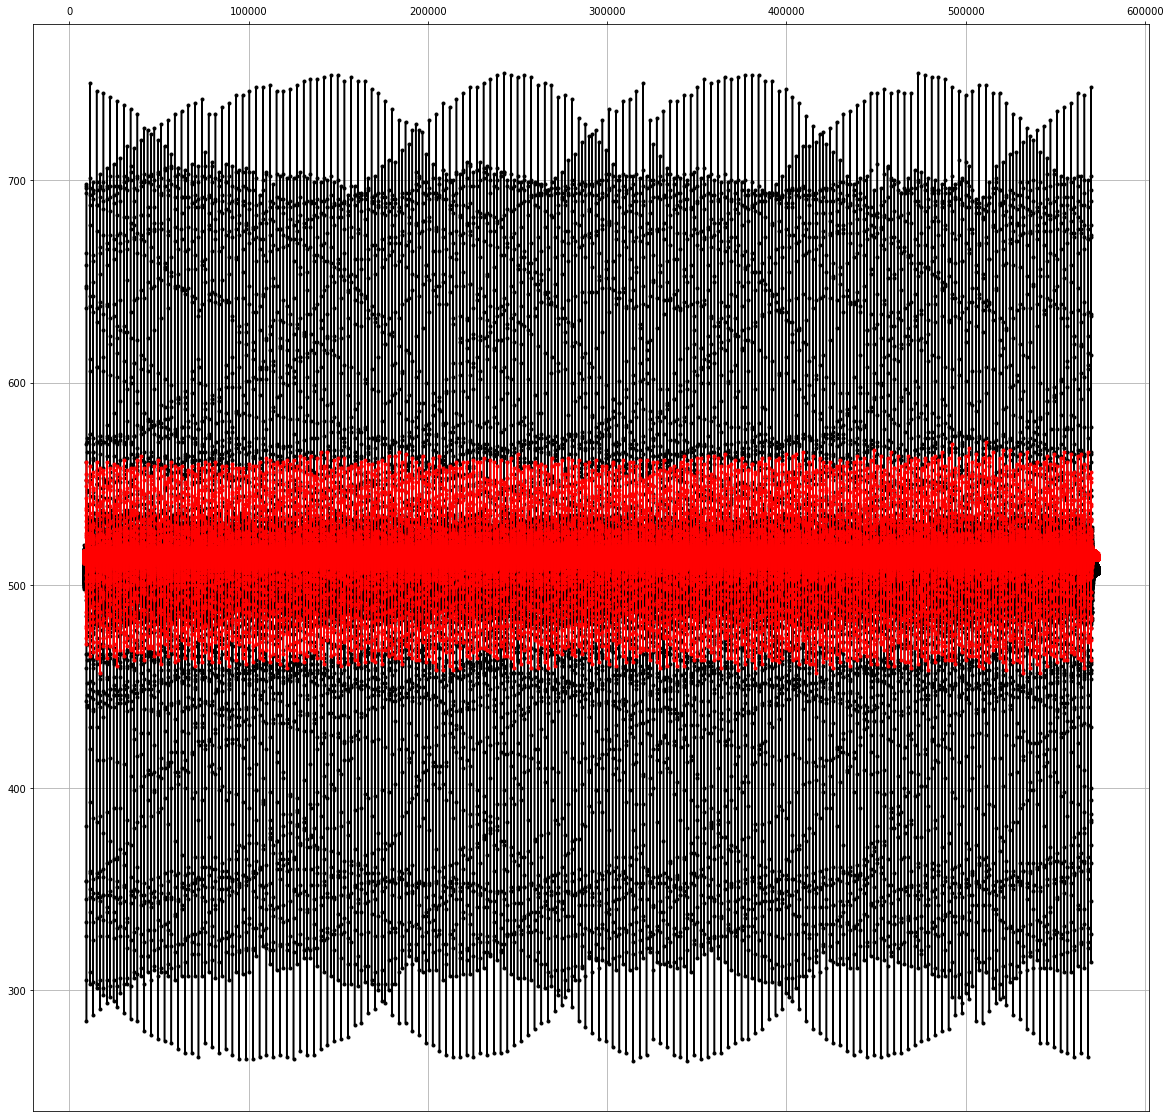

In [476]:
ax = plt.gca()
ax.xaxis.tick_top()
ax.plot(df.index, df["sensor1"], "k.-")
ax.plot(df.index, df["sensor2"], "r.-")
ax.grid()
fig = plt.gcf()
fig.set_size_inches(20, 20)
#x lim
a=4000
b=5000
#plt.xlim(0, 2000)

In [477]:
#import k-means
from sklearn.cluster import KMeans
df = df.reset_index().rename(columns={"index": "time"})

In [478]:
# #try two groups
# kmeans = KMeans(n_clusters=2, random_state=0).fit(df[["sensor1"]])
# df["group"] = kmeans.labels_

In [479]:
# #plot the groups
# ax = plt.gca()
# ax.xaxis.tick_top()
# ax.plot(df[df["group"] == 0]["time"], df[df["group"] == 0]["sensor1"], "k.-", label="Group 0")
# ax.plot(df[df["group"] == 1]["time"], df[df["group"] == 1]["sensor1"], "r.-")
# ax.grid()
# fig = plt.gcf()
# fig.set_size_inches(20, 20)
# ax.legend()


In [480]:
# df = df[df["group"] == 0].drop(columns=["group"])

In [481]:
#identify 20 groups in df_sensor1 by k-means taking time and values into account
kmeans_sensor1 = KMeans(n_clusters=pulses_number, random_state=0).fit(df[["time", "sensor1"]])
kmeans_sensor2 = KMeans(n_clusters=pulses_number, random_state=0).fit(df[["time", "sensor2"]])

#write the clasification for each row in df_sensor1
df["sensor1_pulse"]=kmeans_sensor1.labels_
df["sensor2_pulse"]=kmeans_sensor2.labels_

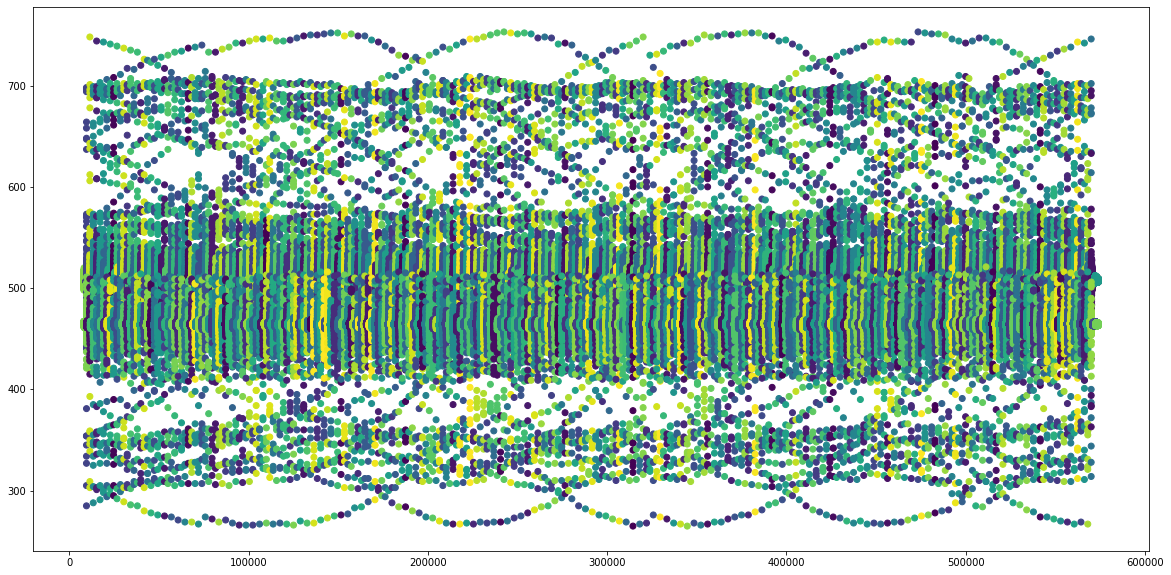

In [482]:
#plot the clasification
plt.figure(figsize=(20, 10))
plt.scatter(df["time"], df["sensor1"], c=df["sensor1_pulse"])
plt.scatter(df["time"], df["sensor2"] - 50, c=df["sensor2_pulse"])
plt.show()


In [483]:
#identify the time of the peak for each group
peaks1 = df[["sensor1", "sensor1_pulse"]].groupby("sensor1_pulse").idxmax().reset_index().rename(columns={"sensor1_pulse": "pulse"})

for pulse in peaks1["pulse"]:
    pulse_df = df.query(f"sensor1_pulse == {pulse}")
    #si el pico no está por encima de la media + 3*desviación estándar, descartar pulso 
    if abs(pulse_df["sensor1"].max()) < pulse_df["sensor1"].mean() + 5*pulse_df["sensor1"].std():
        peaks1 = peaks1.query(f"pulse != {pulse}")

peaks2 = df[["sensor2", "sensor2_pulse"]].groupby("sensor2_pulse").idxmax().reset_index().rename(columns={"sensor2_pulse": "pulse"})

for pulse in peaks2["pulse"]:
    pulse_df = df.query(f"sensor2_pulse == {pulse}")
    #si el pico no está por encima de la media + 3*desviación estándar, descartar pulso 
    if abs(pulse_df["sensor2"].max()) < pulse_df["sensor2"].mean() + 5*pulse_df["sensor2"].std():
        peaks2 = peaks2.query(f"pulse != {pulse}")


In [484]:
peaks = pd.merge(peaks1, peaks2, on="pulse")

In [485]:
peaks

pulse  sensor1  sensor2
0        0   306346   389674
1        2   474868   507084
2        3    16633   264696
3        4   179474    37476
4        5   383973   188958
..     ...      ...      ...
281    294   298772    62080
282    295   209777   372638
283    297   467294   160554
284    298   321487   134037
285    299   215451   128369

[286 rows x 3 columns]

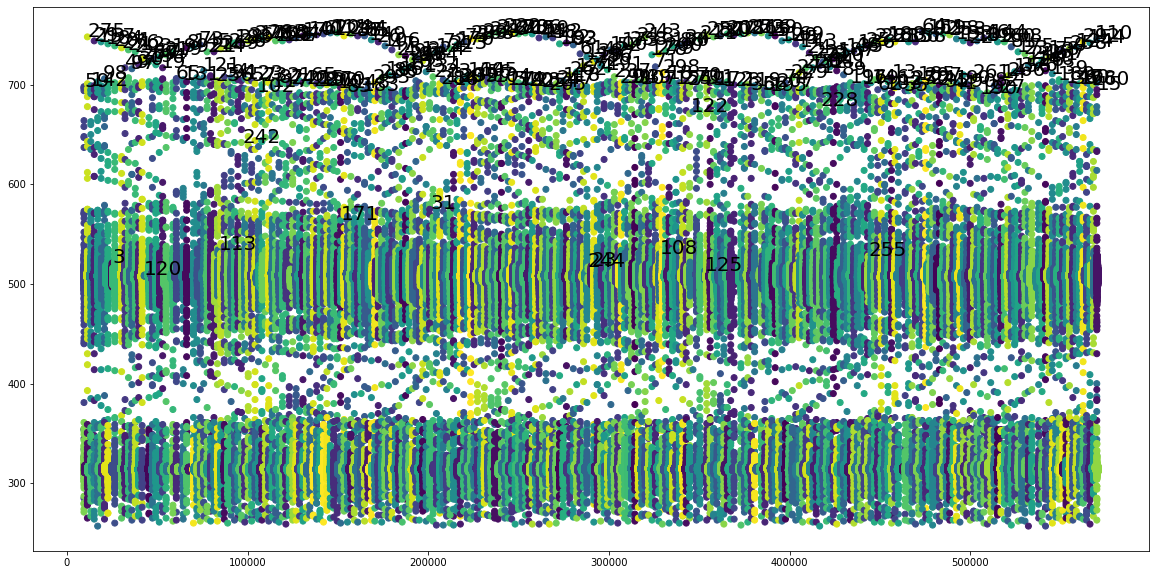

In [486]:
#plot the clasification
df_filtered = df.query("sensor1_pulse in @peaks.pulse and sensor2_pulse in @peaks.pulse")
plt.figure(figsize=(20, 10))
plt.scatter(df_filtered["time"], df_filtered["sensor1"], c=df_filtered["sensor1_pulse"])
plt.scatter(df_filtered["time"], df_filtered["sensor2"] - 200, c=df_filtered["sensor2_pulse"])

#put text over each pulse at the top of the pulse
for peak in peaks["pulse"]:
    peak_df = df_filtered.query(f"sensor1_pulse == {peak}")
    plt.text(peak_df["time"].mean()-peak_df["time"].std(), peak_df["sensor1"].max(), f"{peak}", fontsize=20)
#plt.xlim(4000, 5000)
plt.show()

In [487]:
#df_filtered = df_filtered.query("sensor1_pulse != 17 and sensor2_pulse != 17")

In [488]:
df_filtered = df_filtered[["time", "sensor1", "sensor2"]]

In [489]:
df_filtered

time  sensor1  sensor2
1402      9402    506.0    513.0
1403      9403    506.0    513.0
1404      9404    507.0    514.0
1405      9405    506.0    513.0
1406      9406    506.0    513.0
...        ...      ...      ...
562824  570824    507.0    515.0
562825  570825    509.0    515.0
562826  570826    507.0    514.0
562827  570827    507.0    515.0
562828  570828    508.0    515.0

[519789 rows x 3 columns]

In [461]:
# n_pulses_reclasified = len(peaks["pulse"])
# kmeans_sensor1 = KMeans(n_clusters=n_pulses_reclasified, random_state=0).fit(df_filtered[["time", "sensor1"]])
# kmeans_sensor2 = KMeans(n_clusters=n_pulses_reclasified, random_state=0).fit(df_filtered[["time", "sensor2"]])

# #write the clasification for each row in df_sensor1
# df_filtered["sensor1_pulse"]=kmeans_sensor1.labels_
# df_filtered["sensor2_pulse"]=kmeans_sensor2.labels_

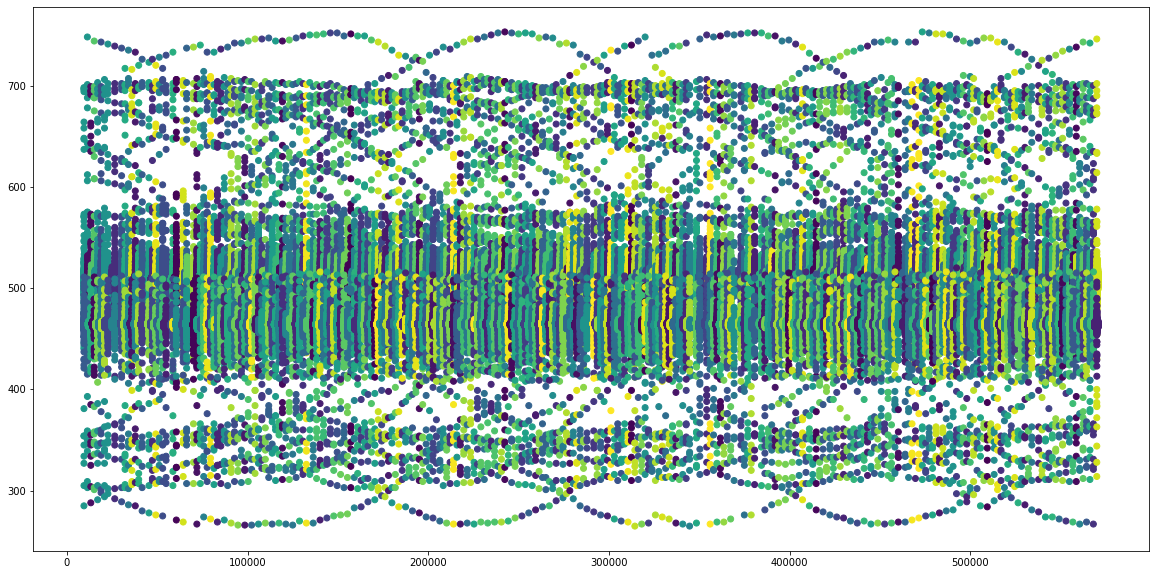

In [462]:
# #plot the clasification
# plt.figure(figsize=(20, 10))
# plt.scatter(df_filtered["time"], df_filtered["sensor1"], c=df_filtered["sensor1_pulse"])
# plt.scatter(df_filtered["time"], df_filtered["sensor2"] - 50, c=df_filtered["sensor2_pulse"])
# #plt.xlim(4000, 5000)
# plt.show()


In [463]:
# #identify the time of the peak for each group
# peaks1_filtered = df_filtered[["sensor1", "sensor1_pulse"]].groupby("sensor1_pulse").idxmax().reset_index().rename(columns={"sensor1_pulse": "pulse"})

# for pulse in peaks1_filtered["pulse"]:
#     pulse_df = df_filtered.query(f"sensor1_pulse == {pulse}")
#     #si el pico no está por encima de la media + 3*desviación estándar, descartar pulso 
#     if abs(pulse_df["sensor1"].max()) < pulse_df["sensor1"].mean() + 5*pulse_df["sensor1"].std():
#         peaks1_filtered = peaks1_filtered.query(f"pulse != {pulse}")

# peaks2_filtered = df_filtered[["sensor2", "sensor2_pulse"]].groupby("sensor2_pulse").idxmax().reset_index().rename(columns={"sensor2_pulse": "pulse"})

# for pulse in peaks2_filtered["pulse"]:
#     pulse_df = df_filtered.query(f"sensor2_pulse == {pulse}")
#     #si el pico no está por encima de la media + 3*desviación estándar, descartar pulso 
#     if abs(pulse_df["sensor2"].max()) < pulse_df["sensor2"].mean() + 5*pulse_df["sensor2"].std():
#         peaks2_filtered = peaks2_filtered.query(f"pulse != {pulse}")


In [464]:
# peaks_filtered = pd.merge(peaks1_filtered, peaks2_filtered, on="pulse")

In [465]:
# peaks_filtered

pulse  sensor1  sensor2
0        0   501371   162454
1        1   149178   471112
2        2   304446   312036
3        3    52609    63980
4        4   406695   391574
..     ...      ...      ...
266    280   459723   236295
267    281   205990    94281
268    282   382250   255228
269    283   463507   164338
270    284   348003   283632

[271 rows x 3 columns]

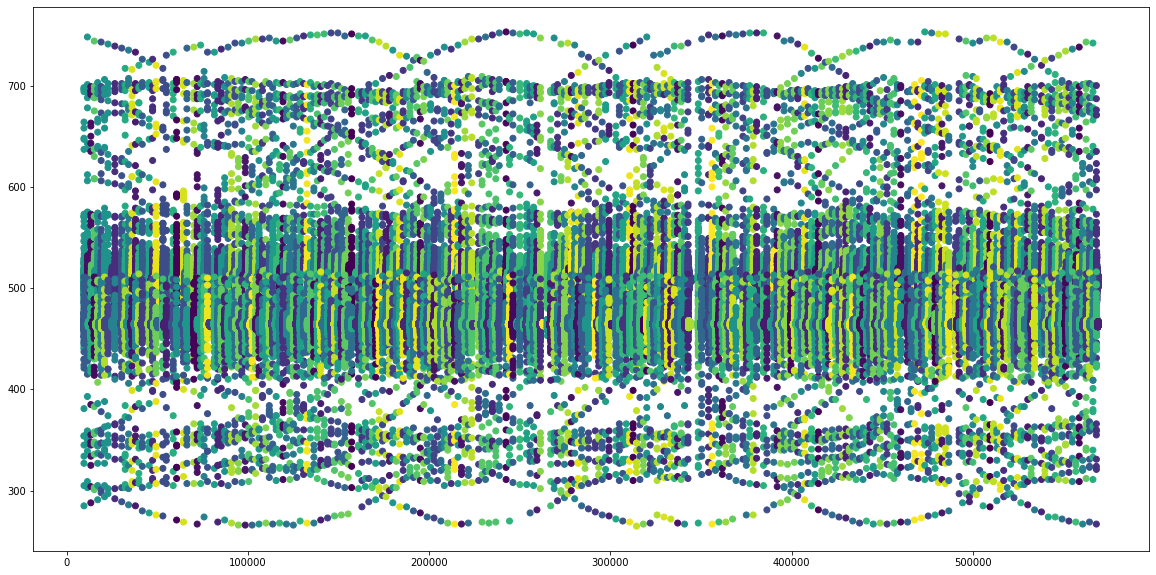

In [466]:
# #plot the clasification
# df_refiltered = df_filtered.query("sensor1_pulse in @peaks_filtered.pulse and sensor2_pulse in @peaks_filtered.pulse")
# plt.figure(figsize=(20, 10))
# plt.scatter(df_refiltered["time"], df_refiltered["sensor1"], c=df_refiltered["sensor1_pulse"])
# plt.scatter(df_refiltered["time"], df_refiltered["sensor2"] - 50, c=df_refiltered["sensor2_pulse"])
# #plt.xlim(4000, 5000)
# plt.show()

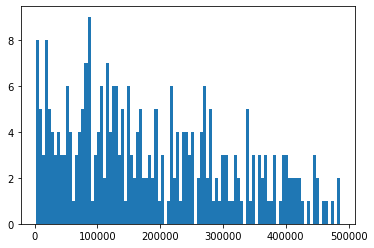

In [495]:
diffs_hist = abs(peaks["sensor1"] - peaks["sensor2"])
#make a histogram of the differences
plt.hist(diffs_hist, bins=100)
plt.show()


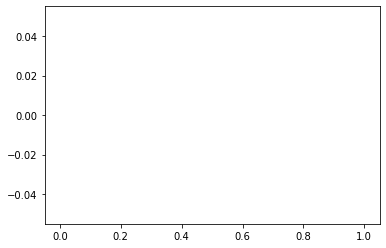

In [496]:
plt.hist(diffs_hist[diffs_hist < 500], bins=50)
plt.show()

In [497]:
gap = int(diffs_hist.mean())

In [498]:
# diffs= abs(peaks_filtered["sensor1"] - peaks_filtered["sensor2"]) # abs(peaks_filtered["sensor1"] - peaks_filtered["sensor2"]).std()
# diffs[np.argmax(diffs)]

In [499]:
time = gap*3/11369
speed = distance/time

In [500]:
pulses_number, speed, gap

(300, 0.012246524729491729, 185669)